### Task-1:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, Input
from PIL import Image, UnidentifiedImageError
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense, Lambda

C:\Users\swast\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\swast\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data Understanding and Visualizations

In [2]:
train_dr = r"C:\Users\swast\Downloads\FruitinAmazon\FruitinAmazon\train"
test_dr = r"C:\Users\swast\Downloads\FruitinAmazon\FruitinAmazon\test"

class_names = sorted(os.listdir(train_dr))
if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [3]:
corrupted_images = []

for class_name in class_names:
    class_path = os.path.join(train_dr, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

if corrupted_images:
    print("\nCorrupted Images Found: ")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")


No corrupted images found.


In [4]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dr, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png','.jpg','.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("="*45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


In [5]:
selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dr, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png','.jpg','.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

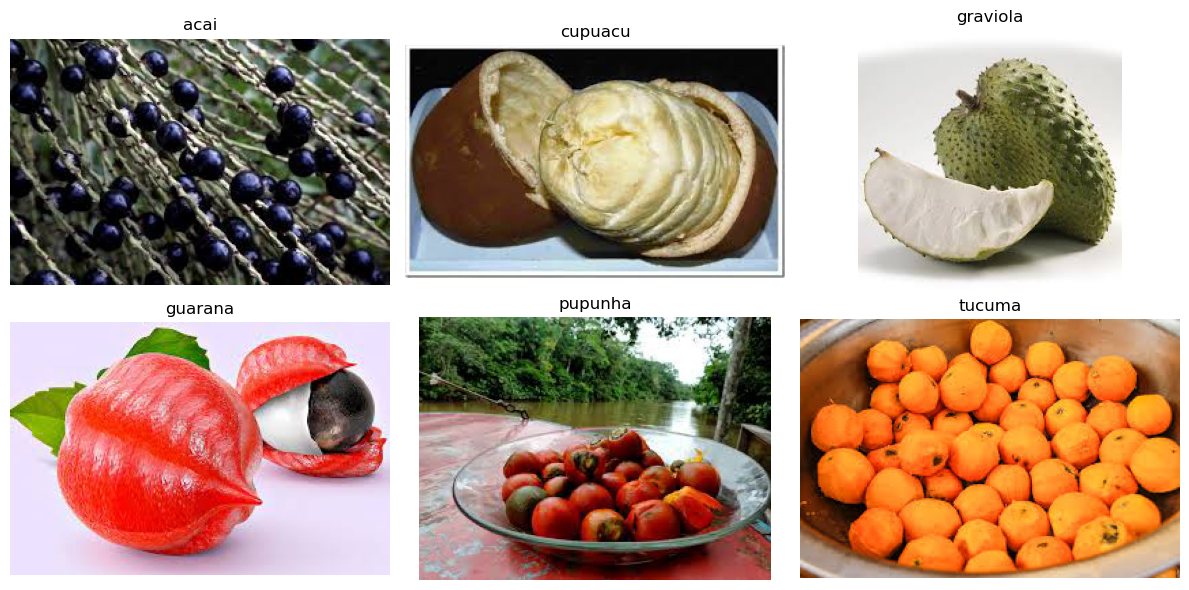

In [6]:
num_classes = len(selected_images)
cols = (num_classes + 1) // 2
rows = 2
fig, axes = plt.subplots(rows,cols,figsize = (12,6))
for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")
plt.tight_layout()
plt.show()

### Data Generation and Pre-Processing

In [7]:
image_size = (128,128)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    train_dr,
    validation_split = 0.2,
    subset = "both",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [8]:
for images, labels in train_ds.take(1): # Take one batch
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 128, 128, 3)
Labels shape: (32,)


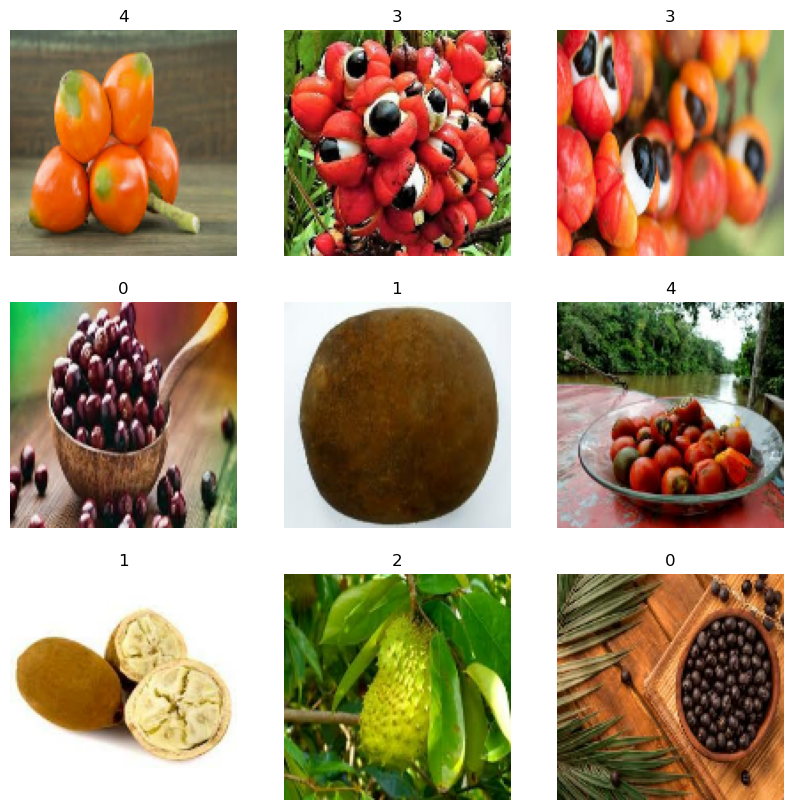

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): #Takes one batch of images from the dataset (train_ds).
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Using image: C:\Users\swast\Downloads\FruitinAmazon\FruitinAmazon\train\acai\images (1).jpeg


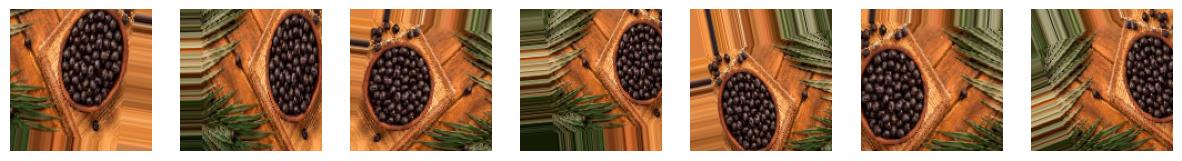

In [10]:
# Pick the first image from the first class folder
first_class_path = os.path.join(train_dr, class_names[0])
image_files = [f for f in os.listdir(first_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    raise ValueError(f"No image files found in {first_class_path}")
    
sample_img_path = os.path.join(first_class_path, image_files[0])
print(f"Using image: {sample_img_path}")

# Load and preprocess image
img = image.load_img(sample_img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
aug_iter = datagen.flow(x, batch_size=1)

# Display augmented images
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
    batch = next(aug_iter)
    ax[i].imshow(batch[0].astype('uint8'))
    ax[i].axis('off')

plt.show()

In [11]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
        return images

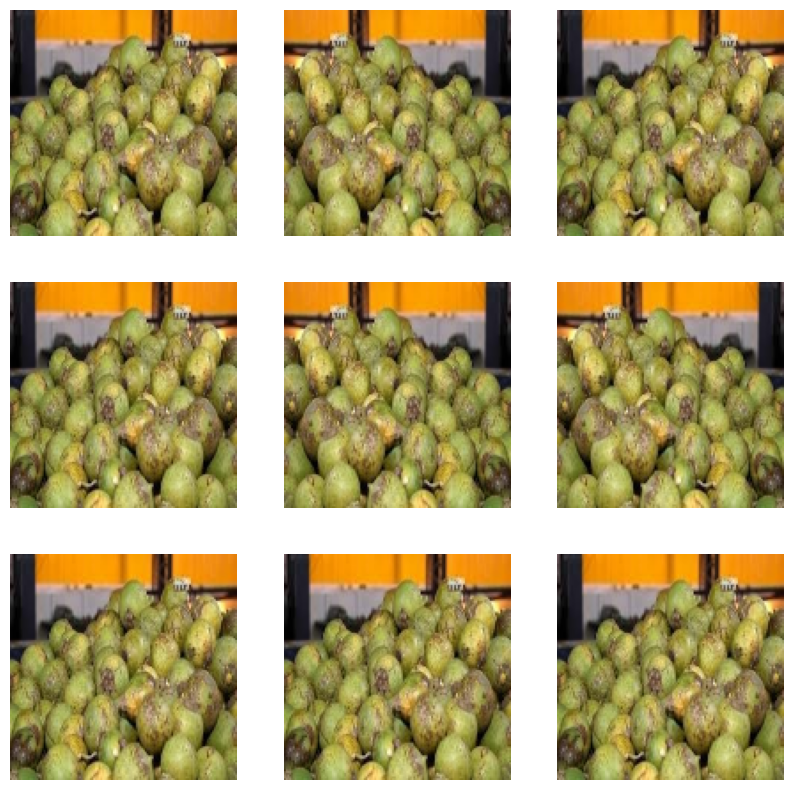

In [12]:
model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    *data_augmentation_layers, # Include augmentation before the model layers
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(10, activation="softmax")
])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

### Data Pre-processing: Scaling the data with Keras

In [13]:
img_height = 128
img_width = 128
batch_size = 16
validation_split = 0.2 

inputs = keras.Input(shape=(img_height,img_width,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

rescale = tf.keras.layers.Rescaling(1./255)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dr,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
augmented_train_ds = train_ds.map( lambda x, y: (data_augmentation(x), y))

# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dr,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
).map(lambda x, y: (rescale(x), y)) #Normalizing validation dataset

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


### Model Building

In [14]:
model = Sequential([
    # Data Augmentation
    layers.Lambda(data_augmentation, input_shape=(128, 128, 3)),
    layers.Rescaling(1./255),

    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the output of the last Conv2D layer
    Flatten(),

    # First Fully Connected Layer
    Dense(512, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Second Fully Connected Layer
    Dense(256, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Third Fully Connected Layer
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Fourth Fully Connected Layer
    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output Layer with 6 neurons (for classification task with 6 classes)
    Dense(6, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


C:\Users\swast\anaconda3\lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,956,166 (34.17 MB)

 Trainable params: 8,953,286 (34.15 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [15]:
# Training the model
history = model.fit(
    augmented_train_ds, # Augmented training dataset
    validation_data=val_ds, # Validation dataset
    epochs=10,  # Number of epochs, you can adjust this
    batch_size=batch_size,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]  # Optional: Early stopping to avoid overfitting
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 734ms/step - accuracy: 0.0648 - loss: 2.6047 - val_accuracy: 0.0000e+00 - val_loss: 1.8360
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - accuracy: 0.1522 - loss: 2.0297 - val_accuracy: 0.0000e+00 - val_loss: 1.9227
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - accuracy: 0.1849 - loss: 2.1391 - val_accuracy: 0.0000e+00 - val_loss: 1.9544
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.2529 - loss: 2.0511 - val_accuracy: 0.0000e+00 - val_loss: 1.9316


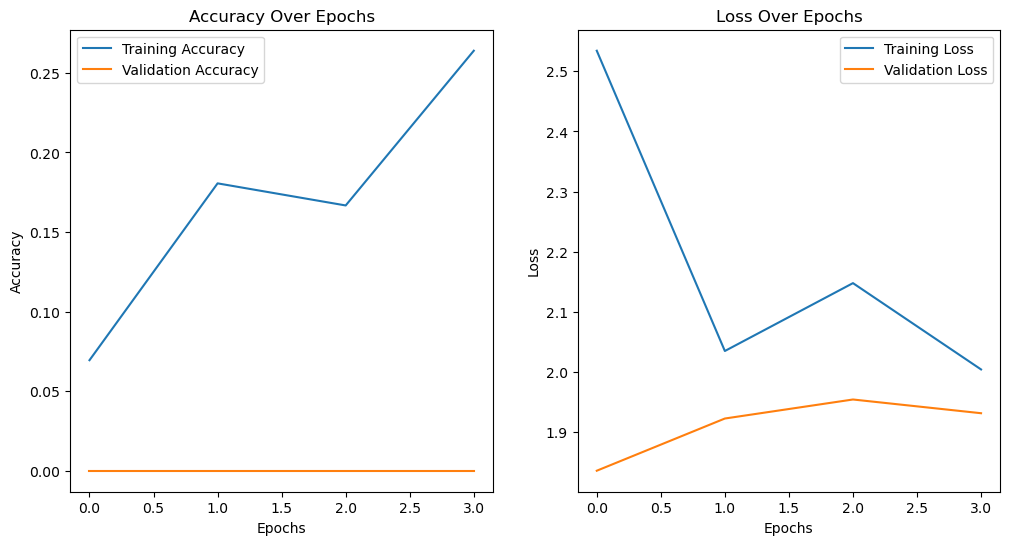

In [16]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Task-2:

In [17]:
# Import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for data preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load training data with image resizing and rescaling
train_data = datagen.flow_from_directory(
    train_dr,  # Replace with your directory path
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical'  
)

validation_data = datagen.flow_from_directory(
    test_dr,  
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical'  
)

Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [18]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(6, activation='softmax')(x)  # 6 classes

In [21]:
from tensorflow.keras.models import Model
model = Model(inputs=base_model.input, outputs=x)

In [22]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, epochs=10, validation_data=validation_data)

C:\Users\swast\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.2706 - loss: 1.8718 - val_accuracy: 0.2667 - val_loss: 1.7078
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.3050 - loss: 1.6237 - val_accuracy: 0.3000 - val_loss: 1.6165
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.6346 - loss: 1.3447 - val_accuracy: 0.4333 - val_loss: 1.4817
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.6130 - loss: 1.1874 - val_accuracy: 0.5667 - val_loss: 1.4194
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.7140 - loss: 1.0092 - val_accuracy: 0.6333 - val_loss: 1.3588
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.8513 - loss: 0.9322 - val_accuracy: 0.4667 - val_loss: 1.3501
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.8630 - loss: 0.7712 - val_accuracy: 0.5333 - val_loss: 1.3071
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8190 - loss: 0.7319 - val_accuracy: 0.6333 - val_loss: 1.2739
Epoch 9/

In [23]:
from sklearn.metrics import classification_report

# Get predictions from the model
predictions = model.predict(validation_data)

# Since predictions are probabilities, we need to convert them to class labels
predicted_labels = predictions.argmax(axis=-1)

# Get the true labels from validation data
true_labels = validation_data.labels

# Print the classification report
print(classification_report(true_labels, predicted_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.20      0.20      0.20         5
           2       0.00      0.00      0.00         5
           3       0.40      0.40      0.40         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5

    accuracy                           0.17        30
   macro avg       0.17      0.17      0.17        30
weighted avg       0.17      0.17      0.17        30

